In [2]:
import pandas as pd
from dateutil.relativedelta import relativedelta

**Outcome Definition: X-Month/Year Survival analysis**

1. Find earliest follow-up death date in TXF_KI with TFL_PX_STAT and TFL_PX_STAT_DT
2. Compute a unified “death_date” as the earlier of OPTN death vs. follow-up death 
3. Determine each patient’s last observed follow-up date
4. define “censor_date”: if we have a death_date, censor there; otherwise censor at last follow-up
5. Compute time-to-event in days
6. Build the event indicator: 1 = died, 0 = censored (alive at last follow-up)
7. Save your new outcome dataset

In [16]:
tx   = pd.read_csv("/Users/chanyoungwoo/Thesis/Data_Extraction/clean_subsets_ver2/tx_ki_subset_ver2.csv",
                   parse_dates=["REC_TX_DT", "PERS_OPTN_DEATH_DT"])
txf  = pd.read_csv("/Users/chanyoungwoo/Thesis/Data_Extraction/clean_subsets_ver2/txf_ki_subset_ver2.csv",
                   parse_dates=["TFL_PX_STAT_DT"])

# find earliest follow-up death date in TXF_KI with TFL_PX_STAT and TFL_PX_STAT_DT
death_fu = (
    txf
    .loc[txf["TFL_PX_STAT"] == "D", ["PX_ID", "TFL_PX_STAT_DT"]]
    .groupby("PX_ID", as_index=False)
    .min()
    .rename(columns={"TFL_PX_STAT_DT": "death_fu_dt"})
)

# merge that back onto the transplant table
df = tx.merge(death_fu, on="PX_ID", how="left")

# Compute a unified “death_date” as the earlier of OPTN death vs. follow-up death
df["death_date"] = df[["PERS_OPTN_DEATH_DT", "death_fu_dt"]].min(axis=1)

# Determine each patient’s last observed follow-up date
last_fu = (
    txf
    .groupby("PX_ID", as_index=False)["TFL_PX_STAT_DT"]
    .max()
    .rename(columns={"TFL_PX_STAT_DT": "last_fu_dt"})
)
df = df.merge(last_fu, on="PX_ID", how="left")

# define “censor_date”: if we have a death_date, censor there; otherwise censor at last follow-up
df["censor_date"] = df["death_date"].fillna(df["last_fu_dt"])

# Compute time-to-event in days
df["time_to_event"] = (df["censor_date"] - df["REC_TX_DT"]).dt.days

# Build the event indicator: 1 = died, 0 = censored (alive at last follow-up)
df["event"] = df["death_date"].notna().astype(int)

# Define a binary “survived X months?” outcome for a chosen horizon X
# X_months = 12
# cutoff   = df["REC_TX_DT"] + pd.to_timedelta(X_months, unit="M")
# df["survived_12m"] = (df["death_date"] > cutoff).fillna(True).astype(int)

# Save your new outcome dataset
df[[
    "PX_ID",
    "REC_TX_DT",       # transplant date
    "death_date",      # date of death if any
    "censor_date",     # last known alive date
    "time_to_event",   # days until event or censor
    "event",           # 1=death, 0=censored
    # covariates for further anaylsis
    "REC_AGE_AT_TX",
    "REC_DGN",
    "REC_FUNCTN_STAT",
    "REC_CREAT",
    "REC_MM_EQUIV_TX",
    "REC_CMV_IGG",
    "REC_HCV_STAT",
    "REC_BMI",
    "REC_MED_COND",
    "DON_AGE",
    "DON_ABO",
    "DON_CREAT",
    "DON_EXPAND_DON_KI",
    #"survived_12m"     # 1=alive past 12 mo, 0=died within 12 mo
]].to_csv("/Users/chanyoungwoo/Thesis/Data_Extraction/outcome_definition/survival_outcomes.csv", index=False)

/var/folders/d8/czws1f3177g_k77xwyh5j8x40000gn/T/ipykernel_10184/1637132440.py:1: DtypeWarning: Columns (17,28,42,43,52,59,60,61,63,64,65,66,68,69,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  tx   = pd.read_csv("/Users/chanyoungwoo/Thesis/Data_Extraction/clean_subsets_ver2/tx_ki_subset_ver2.csv",
/var/folders/d8/czws1f3177g_k77xwyh5j8x40000gn/T/ipykernel_10184/1637132440.py:3: DtypeWarning: Columns (11,21,22,28,29,30,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  txf  = pd.read_csv("/Users/chanyoungwoo/Thesis/Data_Extraction/clean_subsets_ver2/txf_ki_subset_ver2.csv",


**Survival Analysis**

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter

In [28]:
df = pd.read_csv(
    "/Users/chanyoungwoo/Thesis/Data_Extraction/outcome_definition/survival_outcomes.csv",
    parse_dates=["REC_TX_DT", "death_date", "censor_date"],
)

/var/folders/d8/czws1f3177g_k77xwyh5j8x40000gn/T/ipykernel_10184/2462734340.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [29]:
counts = df["event"].value_counts(dropna=False).rename({0: "survived (censored)", 1: "died (event)"})
print("Survival / Event Counts")
print(counts, "\n")

Survival / Event Counts
event
survived (censored)    383429
died (event)           220838
Name: count, dtype: int64 



In [31]:
missing_events = df["time_to_event"].isna().sum()
print(f"Missing in 'time_to_event' column: {missing_events}\n")

Missing in 'time_to_event' column: 20670



In [32]:
print("=== Time-to-Event Summary (days) ===")
print(df["time_to_event"].describe(), "\n")

=== Time-to-Event Summary (days) ===
count    583597.000000
mean       2835.195907
std        2377.243982
min           0.000000
25%        1032.000000
50%        2198.000000
75%        4058.000000
max       13540.000000
Name: time_to_event, dtype: float64 



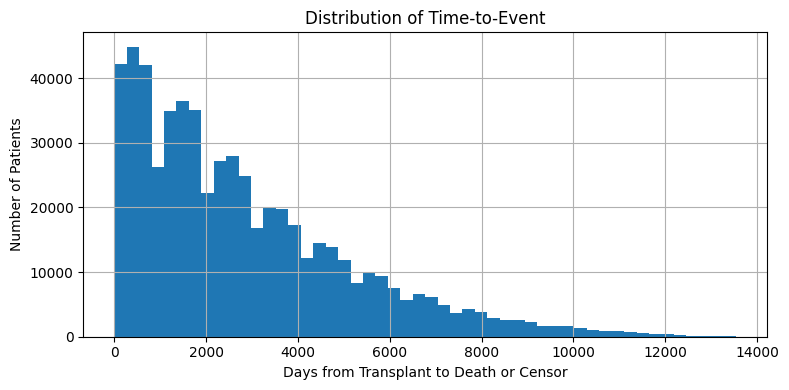

In [33]:
plt.figure(figsize=(8,4))
df["time_to_event"].hist(bins=50)
plt.title("Distribution of Time-to-Event")
plt.xlabel("Days from Transplant to Death or Censor")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

/var/folders/d8/czws1f3177g_k77xwyh5j8x40000gn/T/ipykernel_10184/3578932399.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


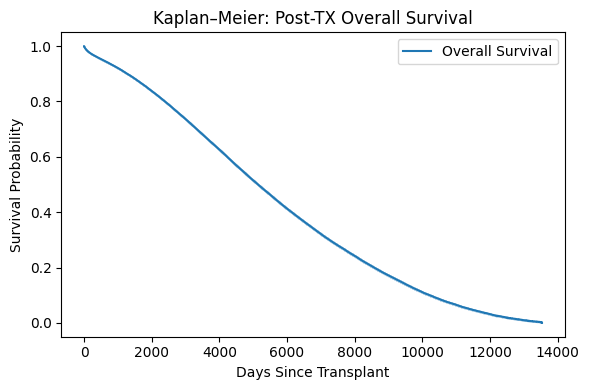

In [ ]:
km_df = df.loc[df["time_to_event"].notna() & df["event"].notna()].copy()

# Kaplan-Meier overall survival curve
kmf = KaplanMeierFitter()
kmf.fit(
    durations=km_df["time_to_event"],
    event_observed=km_df["event"],
    label="Overall Survival",
)

plt.figure(figsize=(6,4))
kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan–Meier: Post-TX Overall Survival")
plt.xlabel("Days Since Transplant")
plt.ylabel("Survival Probability")
plt.tight_layout()
plt.show()


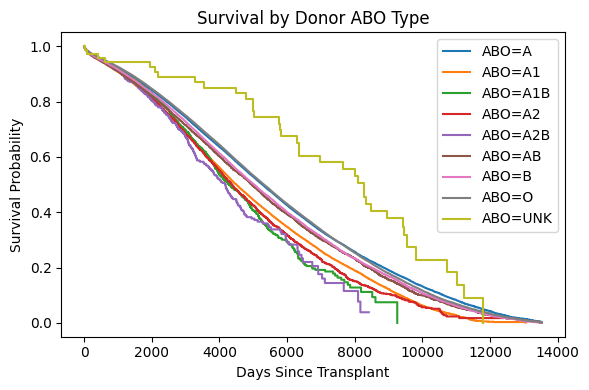

In [ ]:
# Kaplan-Meier curve for Blood Type
plt.figure(figsize=(6,4))
for abo_group, sub in km_df.groupby("DON_ABO"):
    # skip groups with no events/durations
    if sub.shape[0] == 0: 
        continue
    kmf.fit(sub["time_to_event"], sub["event"], label=f"ABO={abo_group}")
    kmf.plot_survival_function(ci_show=False)

plt.title("Survival by Donor ABO Type")
plt.xlabel("Days Since Transplant")
plt.ylabel("Survival Probability")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Create gouping variables
df['age_group'] = pd.cut(df['REC_AGE_AT_TX'], 
                         bins=[0, 50, df['REC_AGE_AT_TX'].max()], 
                         labels=['<50', '≥50'])

# HLA mismatches: up to 2 vs more than 2
df['hla_group'] = pd.cut(df['REC_MM_EQUIV_TX'], 
                         bins=[-1, 2, df['REC_MM_EQUIV_TX'].max()], 
                         labels=['≤2', '>2'])

# donor criteria
df['ecd_group'] = df['DON_EXPAND_DON_KI'].map({0: 'Standard Donor', 1: 'Expanded Criteria Donor'})

kmf = KaplanMeierFitter()

def plot_km(df, group_col, title, legend_title):
    plt.figure(figsize=(8,4))
    for grp in df[group_col].dropna().unique():
        # select only non‐missing time/event for this group
        sub = df[
            (df[group_col] == grp) &
            df["time_to_event"].notna() &
            df["event"].notna()
        ]
        if sub.shape[0] == 0:
            continue
        kmf.fit(
            durations=sub["time_to_event"],
            event_observed=sub["event"],
            label=str(grp)
        )
        kmf.plot(ci_show=True)
    plt.title(title)
    plt.xlabel("Days Since Transplant")
    plt.ylabel("Survival Probability")
    plt.legend(title=legend_title)
    plt.tight_layout()
    plt.show()

plot_km(df, 'age_group', "Survival by Age Group", "Age Group")
plot_km(df, 'hla_group', "Survival by HLA Mismatch", "HLA Mismatch")
plot_km(df, 'ecd_group', "Survival by Donor Criteria", "Donor Type")

TypeError: plot_km() missing 1 required positional argument: 'legend_title'

Test: Cox-Model here has no detailed analysis, for learning purposes only

In [ ]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter

df = pd.read_csv(
    "/Users/chanyoungwoo/Thesis/Data_Extraction/outcome_definition/survival_outcomes.csv",
    parse_dates=["REC_TX_DT", "death_date", "censor_date"]
)

# pick only the covariates that pandas thinks are numeric
numeric_covariates = [
    c for c in [
        "REC_AGE_AT_TX",
        "REC_CREAT",
        "REC_MM_EQUIV_TX",
        "REC_BMI",
        "REC_MED_COND",
        "DON_AGE",
        "DON_CREAT",
        "DON_EXPAND_DON_KI",
        # REC_CMV_IGG and REC_HCV_STAT are object dtype
    ]
    if np.issubdtype(df[c].dtype, np.number)
]

# build model frame
model_df = df[["time_to_event", "event"] + numeric_covariates].dropna()

# fit Cox PH
cph = CoxPHFitter()
cph.fit(model_df, duration_col="time_to_event", event_col="event")
cph.print_summary()


/var/folders/d8/czws1f3177g_k77xwyh5j8x40000gn/T/ipykernel_10184/1940480759.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


<lifelines.CoxPHFitter: fitted with 142280 total observations, 66715 right-censored observations>
             duration col = 'time_to_event'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 142280
number of events observed = 75565
   partial log-likelihood = -814598.43
         time fit was run = 2025-06-23 17:13:36 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
REC_AGE_AT_TX      0.04      1.04      0.00            0.04            0.04                1.04                1.04
REC_CREAT         -0.02      0.98      0.00           -0.02           -0.02                0.98                0.98
REC_MM_EQUIV_TX    0.03      1.03      0.00            0.03            0.03                1.03                1.03
REC_BMI            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
REC_MED_COND      -0.05      0.95      0.02           -0.09           -0.02                0.92                0.98
DON_AGE            0.01      1.01      0.00            0.01            0.01                1.01                1.01
DON_CREAT          0.01      1.01      0.00            0.00            0.02                1.00                1.02
DON_EXPAND_DON_KI  0.10      1.10      0.01            0.07            0.12                1.08                1.13

                   cmp to      z      p  -log2(p)
covariate                                        
REC_AGE_AT_TX        0.00 118.75 <0.005       inf
REC_CREAT            0.00 -16.59 <0.005    203.00
REC_MM_EQUIV_TX      0.00  14.07 <0.005    146.93
REC_BMI              0.00   1.19   0.23      2.09
REC_MED_COND         0.00  -3.30 <0.005     10.04
DON_AGE              0.00  24.67 <0.005    444.11
DON_CREAT            0.00   3.13 <0.005      9.17
DON_EXPAND_DON_KI    0.00   8.25 <0.005     52.53
---
Concordance = 0.67
Partial AIC = 1629212.86
log-likelihood ratio test = 24287.68 on 8 df
-log2(p) of ll-ratio test = inf

**ignificant risk factors**

Age (+4% per year), HLA mismatches (+3%), expanded-criteria donor (+10%), and donor age (+1% per year) all significantly increase post-transplant mortality risk.

Recipient creatinine shows a small but significant protective effect (HR<1), perhaps reflecting better pre-op kidney function or selection.

Non-significant or minimal effects

BMI has essentially no effect on survival here.

Recipient medical‐condition code has a modest protective association, but you may want to investigate its coding and clinical meaning.

Model performance

A c-index of 0.67 indicates fair discriminatory ability; there’s room for improvement, perhaps by adding other key predictors (e.g. PRA, functional status, comorbidities).

The highly significant likelihood‐ratio test confirms these covariates as a group meaningfully improve survival prediction over a null model.